# Construction of a prediction model for Covid19
## Part 2 (for part one look at the DataExploration notebook)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier

from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from WebApp.CovidClinicalData import DataImputer

from scipy.stats import ttest_ind
from scipy.stats import chisquare
from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

We read the data file created in the Part 1 notebook

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


We are going to split the data into a training set on which we will do the parameter tuning and a test set on which we will evaluate the models' performance

In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]
X, test_x, y, test_y = train_test_split(X, y, test_size=.1)

## Splitting the data

Given that the data appears in the dictionary as taken by blocks (and seen how that matches the proportion of null values for every group) I have decided to split the data into the 4 types:<br>
- <u>Epidemiological factors:</u> 'age', 'high_risk_exposure_occupation' and 'high_risk_interactions'. These will be included in all datasets since I believe it might affect the results greatly and could be easily ignored for experimentation purposes. 
- <u>Comorbidities:</u> All columns from 'diabetes' to 'smoker'. Since this is the most complete dataset (almost all instances in the original dataset are not null) we will start with this.
- <u>Vitals:</u> All of the continues values ('temperature', 'pulse', etc.) I try to use simple linear regression and compare it against both trees and xgboost algorithms.
- <u>Clinician Assessed symptoms:</u> 'ctab', 'labored_respiration', 'rhonchi' and 'wheezes'. I will use naive bayes, trees and/or xgboost.
- <u>Patient reported symptoms:</u> All remaining columns. Again, naive bayes, trees and/or xgboost.

After I have each dataset, I will impute the null corresponding to the most frequent in each case and train several models for each one of them

In [4]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [5]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [6]:
def reduce_training_set(data_x, data_y, ratio=1):
    '''
    Undersamples the 'Negative' classes so we end up with nPositives * ratio 'Negative' examples
    '''
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum() * ratio)
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    '''
        Gets evaluation metrics for a set of predictions
        values: a tuple in the form of '(actual, predictions)'
    '''
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return recall, f1 


In [7]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight=None)
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [23]:
def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, sample_weights=None):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = min(positive_index.shape[0] * ratio_negatives_to_positives, data_y[data_y == "Negative"].index.shape[0])
    
    fold_size = positive_index.shape[0] // folds
    fold_size_neg = fold_size * ratio_negatives_to_positives
    
    results = np.zeros((folds,2,3)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = DataImputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size_neg), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        
        rest_of_x = data_x.loc[~data_x.index.isin(train_x.index)] ## Al data not used by training
        valid_x = pd.concat([rest_of_x[data_y == "Negative"].sample(fold_size_neg), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        train_x = imputer.fit_transform(train_x, train_y)
        valid_x = imputer.transform(valid_x)
        
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    return results.mean(axis=0), results.std(ddof=1, axis=0) # 'ddof=1' means the divisor will be n-1 (ddof is degrees of freedom) since this is a sample of all possible results

def run_threshold(data_x, data_y, model, thresholds=np.linspace(0,1, num=11), folds=10, ratio_negatives_to_positives=1):
    
    threshold_scores = np.zeros((5,thresholds.shape[0]))
    i = 0 #the threshold index im in
    for t in thresholds:      
        print("Threshold:", t)
        results_mean, results_std = cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=ratio_negatives_to_positives, class_threshold=t, plot_roc=False, feature_importances=False)
         
        for metric in range(5):
            threshold_scores[metric,i] = results_mean[1][metric]      
        i+=1
    
    plt.figure(figsize=(21,7))
    plt.plot(thresholds, threshold_scores[1], label="Recall")
    plt.plot(thresholds, threshold_scores[4], label="F1 score")
    plt.legend()
    plt.show()
    
    display(pd.DataFrame(threshold_scores, index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds))
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    result_table = np.zeros((2,len(models), 3))
    i = 0
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            results_mean, results_std = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)   
            
            result_table[0,i] = results_mean[1]
            result_table[1,i] = results_std[1]
            
            print("")
            print("Mean metrics")
            display(pd.DataFrame(results_mean, index=["Training", "Validation"], columns=["Recall","F1", "ROC_AUC"]))
            print("Spread in metrics (sample std)")
            display(pd.DataFrame(results_std, index=["Training", "Validation"], columns=["Recall","F1", "ROC_AUC"]))
            
        except Exception as e:
            print(e)
        i+=1
        
    display(pd.DataFrame(result_table[0], index=models.keys(), columns=["Recall", "F1", "ROC_AUC"]))
    
    #The conficdence interval
    lower_array = np.around(result_table[0]- 2*(result_table[1] / np.sqrt(folds)), decimals=4)
    upper_array = np.around(result_table[0]+ 2*(result_table[1] / np.sqrt(folds)), decimals=4)
    lower_bound_df = pd.DataFrame(lower_array.astype("str"), index=models.keys(), columns=["Recall", "F1", "ROC_AUC"]) # We use a value of 2 stds for a 95% confidence level
    upper_bound_df = pd.DataFrame(upper_array.astype("str"), index=models.keys(), columns=["Recall", "F1", "ROC_AUC"])
    interval_df = lower_bound_df + "-" + upper_bound_df
    
    display(interval_df)

def eval_final_performance(train_x, train_y, test_x, test_y, model, threshold=.5):
    smote = SMOTE(sampling_strategy=1, random_state=0)
    imp_x = train_x.copy()
    imputer = Imputer()
    imp_x = imputer.fit_transform(sd_imp, train_y)
    X_resample, y_resample = smote.fit_resample(sd_imp, y[sd_imp.index])
    print("Resampling done... Imputing data")
    imp_x = test_x.copy()
    imp_x["pam"] = calculate_pam(imp_x)
    imp_x = imp_x[selected_dataset.columns]
    imp_x = imputer.transform(imp_x)
    print("Imputing done... training model")
    model.fit(X_resample, y_resample)
    print("Training done... predictiong results")
    t_preds = model.predict_proba(X_resample)
    t_preds = pd.cut(t_preds[:,1], [-1, threshold, 1.1], labels=["Negative", "Positive"], right=False)
    preds = model.predict_proba(imp_x)
    preds = pd.cut(preds[:,1], [-1, threshold, 1.1], labels=["Negative", "Positive"], right=False)    

    print("Done! Doing dummy models now")
    random_even = DummyClassifier(strategy="uniform")
    random_even.fit(X_resample, y_resample)

    random_stratified = DummyClassifier(strategy="stratified")
    random_stratified.fit(X_resample, y_resample)
    
    print("Confusion matrix")
    confusion_matrix(test_y, preds)
    
    pd.DataFrame([get_metrics(y_resample, t_preds), get_metrics(test_y, preds), get_metrics(test_y, random_even.predict(imp_x)), get_metrics(test_y, random_stratified.predict(imp_x))], 
                 index=["Training Data", "Test Data", "Random 50/50", "Random stratified"], columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"])

## Using Significance (z) tests and $\chi^{2}$ tests to determine important features

In [9]:
X.describe(include="all")

,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,smoker,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
count,46491.000000,46448,42719,46491,46491,46491,46491,46491,46491,46491,...,46414,46414.000000,46431,46442,46435,46428,46428,46431,46435,46435
unique,NaN,2,2,2,2,2,2,2,2,2,...,2,NaN,2,2,2,2,2,2,2,2
top,NaN,False,False,False,False,False,False,False,False,False,...,False,NaN,False,False,False,False,False,False,False,False
freq,NaN,40657,32402,45983,46177,43248,46290,44640,46298,43651,...,43556,NaN,44768,41090,41702,45854,45833,43401,43471,41246
mean,2.268245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.082734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.141464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.343811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Significance (z) tests for the difference between the means of the Positive result group and the Negative result group

$H_{0}$: The difference between the means of the Positive and Negative result groups should be 0. <br>
$H_{a}$: The difference between the means of the Positive and Negative result groups is different than 0. <br>
$\alpha$: 0.005

In [10]:
def highlight_max(x):
    return ['color: red' if v < .005 else ''
                for v in x]

values = []
for feature in X.describe().columns:
    values.append(ttest_ind(X.loc[(y == "Positive"), feature], X.loc[(y == "Negative"), feature], nan_policy="omit", equal_var=False))
    
significance_tests = pd.DataFrame(values, index=X.describe().columns, columns=["t-statistic", "p-value"])
significance_tests.style.apply(highlight_max, axis=1, subset=["p-value"])

,t-statistic,p-value
age,-2.108787,0.035186
temperature,10.620510,0.000000
pulse,10.547980,0.000000
sys,2.830173,0.004747
dia,3.816617,0.000144
rr,4.956794,0.000001
sats,-1.784982,0.074569
days_since_symptom_onset,-8.516246,0.000000
cough_severity,14.321435,0.000000
sob_severity,3.810428,0.000146


As we can see, we can reject $H_{0}$ for any of the features, since all of them have a z-value larger in magnitude than 1.96. This was to be expected because the dataset was curated in a previous notebook removing a lot of unnecessary variables. We can see that the most significant variables here are <b>temperature</b>, <b>pulse</b> and <b>days_since_symptom_onset</b>. (We do not count <b>cough_severity</b> and <b>sob_severity</b> since this are encoded ordinal variables).


Also, I engineered a new feature "Mean Arterial Pressure" (`pam` in spanish) in order to get rid of the correlated systolic and diastolic pressure.

In [11]:
def calculate_pam(data_x):
    return data_x["dia"] + ((data_x["sys"] - data_x["dia"])/3)

pam = calculate_pam(X)
print(ttest_ind(pam[(y == "Positive")], pam[(y == "Negative")], equal_var=False, nan_policy="omit"))

Ttest_indResult(statistic=3.592880362970864, pvalue=0.0003431441462065953)


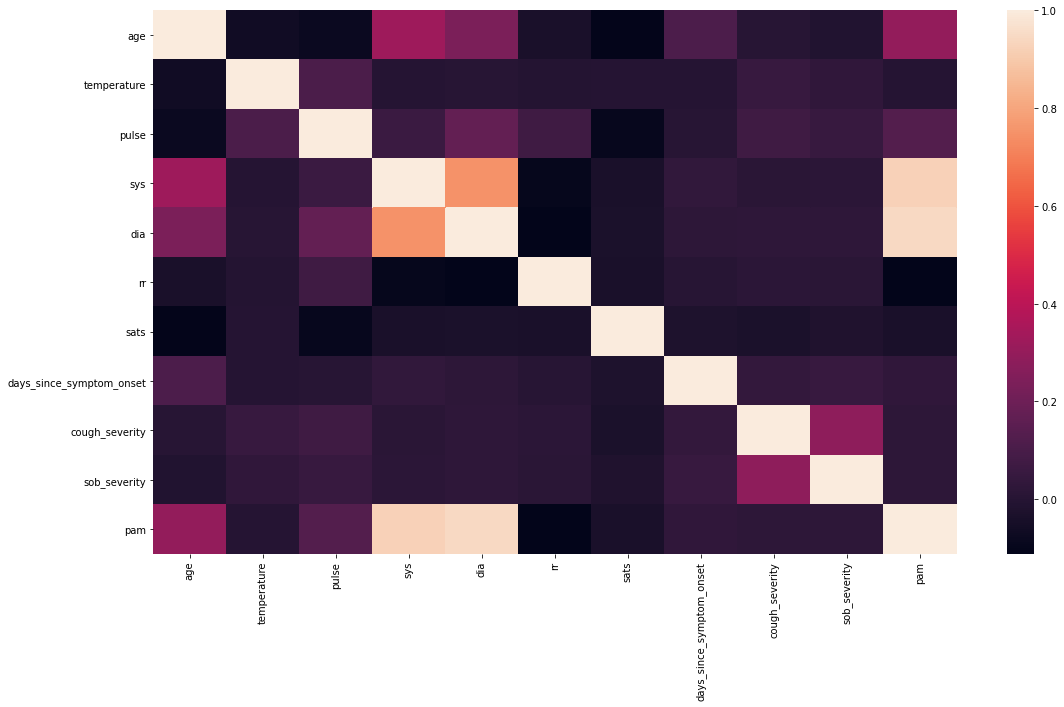

In [12]:
plt.figure(figsize=(18, 10))
sns.heatmap(pd.concat([X[significance_tests.index], pam], axis=1).corr(), xticklabels=list(significance_tests.index) + ["pam"], yticklabels= list(significance_tests.index) + ["pam"])
plt.show()

The new feature seems to be quite strong at predicting results since it's p-value is below our significance level so I added it to the `DataImputer` class. Also, as we can see above, <b>sys</b> and <b>dia</b> result to be highly correlated with each other as well as to a certain degree with other variables while <b>pam</b> does not seem to be correlated with anything but <b>age</b> to a lesser extent. Because of that, I will drop them during imputation.

### $\chi^{2}$ tests for independence between the covid test result and each categorial feature's values

$\alpha$: 0.005<br>

In [13]:
categorical_columns = [x for x in X.columns if X[x].dtype != "float64" or x == "cough_severity" or x == "sob_severity"]

values = []
for column in categorical_columns:
    
    a = all_data.groupby(by=["covid19_test_results", column], as_index=False).size().pivot(index=column, columns="covid19_test_results")
    
    #This is the formula for calculating the expected values of each cell:
    # - The a/a is just to make sure the matrix becomes 1
    # - The formula states that we have to calculate the probability of each cell, multiply those probabilities, and then multiply them by n. Doing algebra we arrive at the formula below
    #   (X/n) is the prob of X. (A/n) is the prob of A. To obtain the expected value of cell AX we do n*(X/n)*(A/n), which can just be reduced to (X*A)/n
    expected_values = (a/a) * (a.sum(axis=0)/a.values.sum()) * (a.sum(axis=1).values.reshape((a.shape[0], 1)))
        
    values.append(chisquare(f_obs=a.values.flatten(), f_exp=expected_values.values.flatten()))

chisquare_tests = pd.DataFrame(values, index=categorical_columns, columns=["chi-statistic", "p-value"])
chisquare_tests.style.apply(highlight_max) 

,chi-statistic,p-value
age,13.313841,0.064821
high_risk_exposure_occupation,29.764927,0.000002
high_risk_interactions,9.141420,0.027469
diabetes,15.903699,0.001187
chd,0.072217,0.994949
htn,0.048312,0.997216
cancer,0.016782,0.999425
asthma,4.264574,0.234276
autoimmune_dis,1.766320,0.622291
smoker,1.873253,0.599126


### Combine the most important numeric and categorical features according to the significance levels

In [14]:
numerical_features = significance_tests[significance_tests["p-value"] < 0.005].index
categorical_features = chisquare_tests[chisquare_tests["p-value"] < 0.005].index
selected_features = numerical_features.union(categorical_features).tolist()
print(len(selected_features))
selected_features

24


['cough',
 'cough_severity',
 'ctab',
 'days_since_symptom_onset',
 'dia',
 'diabetes',
 'diarrhea',
 'fatigue',
 'fever',
 'headache',
 'high_risk_exposure_occupation',
 'loss_of_smell',
 'loss_of_taste',
 'muscle_sore',
 'pulse',
 'rhonchi',
 'rr',
 'runny_nose',
 'sob',
 'sob_severity',
 'sore_throat',
 'sys',
 'temperature',
 'wheezes']

## Model development

In [24]:
models ={
    "MultinomialNB" : GaussianNB(priors=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=100),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression(),
    "Ada Boost" : AdaBoostClassifier()
}

In [25]:
run_models(X, y, models, folds=30, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.474669,0.573658,0.724511
Validation,0.473386,0.570936,0.699659


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.062795,0.030029,0.011643
Validation,0.077006,0.066269,0.056287


Random Forest (100 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.957074,0.865776,0.904313
Validation,0.952963,0.661773,0.679410


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.013591,0.008202,0.007624
Validation,0.030614,0.019963,0.067227


XGBoost Classifier
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.999383,0.999221,0.999997
Validation,0.726772,0.632977,0.649404


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.000700,0.000594,0.000005
Validation,0.085407,0.057315,0.078900


SVM
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.721283,0.757046,0.834776
Validation,0.820000,0.656280,0.688490


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.112145,0.073206,0.026287
Validation,0.127353,0.046876,0.087623


KNN
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.999903,0.999951,1.000000
Validation,0.893651,0.635518,0.497196


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.000297,0.000149,1.446949e-07
Validation,0.060902,0.029743,7.427758e-02


Logistic Regression
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.681273,0.726884,0.818408
Validation,0.752566,0.664586,0.724100


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.056271,0.040850,0.032009
Validation,0.116876,0.052863,0.063447


Ada Boost
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.921003,0.892105,0.968186
Validation,0.789233,0.659444,0.690789


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.011489,0.005976,0.002779
Validation,0.101459,0.054012,0.066868


,Recall,F1,ROC_AUC
MultinomialNB,0.473386,0.570936,0.699659
Random Forest (100 estimators),0.952963,0.661773,0.679410
XGBoost Classifier,0.726772,0.632977,0.649404
SVM,0.820000,0.656280,0.688490
KNN,0.893651,0.635518,0.497196
Logistic Regression,0.752566,0.664586,0.724100
Ada Boost,0.789233,0.659444,0.690789


,Recall,F1,ROC_AUC
MultinomialNB,0.4453-0.5015,0.5467-0.5951,0.6791-0.7202
Random Forest (100 estimators),0.9418-0.9641,0.6545-0.6691,0.6549-0.704
XGBoost Classifier,0.6956-0.758,0.612-0.6539,0.6206-0.6782
SVM,0.7735-0.8665,0.6392-0.6734,0.6565-0.7205
KNN,0.8714-0.9159,0.6247-0.6464,0.4701-0.5243
Logistic Regression,0.7099-0.7952,0.6453-0.6839,0.7009-0.7473
Ada Boost,0.7522-0.8263,0.6397-0.6792,0.6664-0.7152


In [26]:
run_models(X[selected_features], y, models, folds=30, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.466264,0.571698,0.720081
Validation,0.457407,0.561782,0.708873


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.010851,0.008578,0.013331
Validation,0.057606,0.044966,0.048953


Random Forest (100 estimators)
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.955322,0.865388,0.908150
Validation,0.957646,0.659652,0.667772


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.015765,0.006034,0.008979
Validation,0.034677,0.019622,0.047967


XGBoost Classifier
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.997110,0.997239,0.999959
Validation,0.734021,0.635321,0.650952


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.001854,0.000987,0.000035
Validation,0.088519,0.043840,0.060399


SVM
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.715680,0.746271,0.829686
Validation,0.794206,0.641519,0.668627


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.162454,0.105527,0.027396
Validation,0.160400,0.037663,0.080392


KNN
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.999351,0.999675,0.999999
Validation,0.880265,0.634170,0.515536


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.000782,0.000391,9.099945e-07
Validation,0.068762,0.032482,8.561209e-02


Logistic Regression
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.665627,0.713448,0.808462
Validation,0.736402,0.661972,0.715254


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.073637,0.050008,0.035341
Validation,0.106766,0.048020,0.057703


Ada Boost
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣

Mean metrics


,Recall,F1,ROC_AUC
Training,0.917299,0.888781,0.966304
Validation,0.787222,0.663477,0.685135


Spread in metrics (sample std)


,Recall,F1,ROC_AUC
Training,0.012767,0.008035,0.003170
Validation,0.075664,0.039697,0.062801


,Recall,F1,ROC_AUC
MultinomialNB,0.457407,0.561782,0.708873
Random Forest (100 estimators),0.957646,0.659652,0.667772
XGBoost Classifier,0.734021,0.635321,0.650952
SVM,0.794206,0.641519,0.668627
KNN,0.880265,0.634170,0.515536
Logistic Regression,0.736402,0.661972,0.715254
Ada Boost,0.787222,0.663477,0.685135


,Recall,F1,ROC_AUC
MultinomialNB,0.4364-0.4784,0.5454-0.5782,0.691-0.7267
Random Forest (100 estimators),0.945-0.9703,0.6525-0.6668,0.6503-0.6853
XGBoost Classifier,0.7017-0.7663,0.6193-0.6513,0.6289-0.673
SVM,0.7356-0.8528,0.6278-0.6553,0.6393-0.698
KNN,0.8552-0.9054,0.6223-0.646,0.4843-0.5468
Logistic Regression,0.6974-0.7754,0.6444-0.6795,0.6942-0.7363
Ada Boost,0.7596-0.8149,0.649-0.678,0.6622-0.7081
